In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

import torch
import spacy
from torch import nn, optim
from transformers import pipeline
from functools import partial

nlp = spacy.load("en_core_web_trf")

/home/ytchen/.local/lib/python3.8/site-packages/spacy/util.py:730: UserWarning: [W095] Model 'en_core_web_trf' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.1.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
imdb_data=pd.read_csv('./data/train.csv')
print(imdb_data.shape)
imdb_data.head(5)

(29341, 3)


,ID,review,sentiment
0,41411,I watched this film because I'm a big fan of R...,0
1,37586,It does not seem that this movie managed to pl...,1
2,6017,"Enough is not a bad movie , just mediocre .",0
3,44656,my friend and i rented this one a few nights a...,0
4,38711,"Just about everything in this movie is wrong, ...",0


In [3]:
imdb_test_data=pd.read_csv('./data/test.csv')
print(imdb_test_data.shape)
imdb_test_data.head(5)

(29341, 2)


,ID,review
0,22622,Robert Lansing plays a scientist experimenting...
1,10162,"Well I've enjoy this movie, even though someti..."
2,17468,First things first - though I believe Joel Sch...
3,42579,I watched this movie on the grounds that Amber...
4,701,A certain sexiness underlines even the dullest...


In [4]:
MAX_LEN = 512

In [6]:
# https://towardsdatascience.com/sentiment-analysis-with-pretrained-transformers-using-pytorch-420bbc1a48cd
sentiment_analysis = pipeline("sentiment-analysis")

In [7]:
results = sentiment_analysis(["We are very happy to show you the 🤗 Transformers library.",
           "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


In [8]:
s = "I'm extremely excited but today weather is not good."
print(s)
sentiment_analysis(s)[0]

I'm extremely excited but today weather is not good.


{'label': 'NEGATIVE', 'score': 0.9990981817245483}

In [10]:
imdb_data['review'] = imdb_data['review'].astype(str)

In [11]:
%%time
imdb_data['review_pruned_length'] = imdb_data['review'].apply(lambda x : " ".join(x.split( )[:MAX_LEN]))

CPU times: user 618 ms, sys: 11.6 ms, total: 630 ms
Wall time: 631 ms


In [12]:
imdb_data

,ID,review,sentiment,review_pruned_length
0,41411,I watched this film because I'm a big fan of R...,0,I watched this film because I'm a big fan of R...
1,37586,It does not seem that this movie managed to pl...,1,It does not seem that this movie managed to pl...
2,6017,"Enough is not a bad movie , just mediocre .",0,"Enough is not a bad movie , just mediocre ."
3,44656,my friend and i rented this one a few nights a...,0,my friend and i rented this one a few nights a...
4,38711,"Just about everything in this movie is wrong, ...",0,"Just about everything in this movie is wrong, ..."
...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,It 's one of the most honest films ever made a...
29337,453,An absorbing and unsettling psychological drama .,1,An absorbing and unsettling psychological drama .
29338,13097,"Soylent Green IS...a really good movie, actual...",1,"Soylent Green IS...a really good movie, actual..."
29339,26896,There just isn't enough here. There a few funn...,0,There just isn't enough here. There a few funn...


In [13]:
# imdb_data.to_csv('./data/pruned_train.csv', index=0)

In [16]:
# filtered weird sentiment data
imdb_data['sentiment'] = imdb_data['sentiment'].astype(str)

imdb_data = imdb_data[~imdb_data['sentiment'].str.contains(r'[^0-9]')]
imdb_data = imdb_data[~imdb_data['sentiment'].str.contains('[A-Za-z]')]

In [18]:
imdb_data['sentiment'] = imdb_data['sentiment'].astype(np.int8)
imdb_data['review_pruned_length'] = imdb_data['review_pruned_length'].astype(str)

imdb_data.reset_index(drop=True, inplace=True)

<AxesSubplot:>

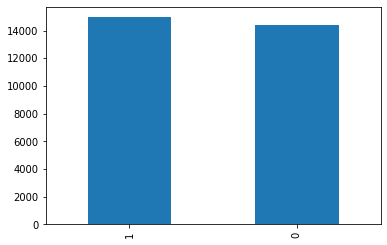

In [19]:
imdb_data.sentiment.value_counts().plot(kind='bar')

In [20]:
imdb_data

,ID,review,sentiment,review_pruned_length
0,41411,I watched this film because I'm a big fan of R...,0,I watched this film because I'm a big fan of R...
1,37586,It does not seem that this movie managed to pl...,1,It does not seem that this movie managed to pl...
2,6017,"Enough is not a bad movie , just mediocre .",0,"Enough is not a bad movie , just mediocre ."
3,44656,my friend and i rented this one a few nights a...,0,my friend and i rented this one a few nights a...
4,38711,"Just about everything in this movie is wrong, ...",0,"Just about everything in this movie is wrong, ..."
...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,It 's one of the most honest films ever made a...
29337,453,An absorbing and unsettling psychological drama .,1,An absorbing and unsettling psychological drama .
29338,13097,"Soylent Green IS...a really good movie, actual...",1,"Soylent Green IS...a really good movie, actual..."
29339,26896,There just isn't enough here. There a few funn...,0,There just isn't enough here. There a few funn...


In [21]:
%%time

result = []
score = []
for txt in tqdm(imdb_data['review_pruned_length']):
    try:
        result.append('0' if sentiment_analysis(txt)[0]['label'] == 'NEGATIVE' else '1')
        score.append(sentiment_analysis(txt)[0]['score'])
    except:
        result.append('1')
        score.append(0.0)

100%|██████████| 29341/29341 [2:08:50<00:00,  3.80it/s]

CPU times: user 8h 10min 47s, sys: 1min 33s, total: 8h 12min 20s
Wall time: 2h 8min 50s


In [22]:
imdb_data['pred_sentiment'] = result
imdb_data['score'] = score

In [23]:
imdb_data

,ID,review,sentiment,review_pruned_length,pred_sentiment,score
0,41411,I watched this film because I'm a big fan of R...,0,I watched this film because I'm a big fan of R...,0,0.999600
1,37586,It does not seem that this movie managed to pl...,1,It does not seem that this movie managed to pl...,1,0.000000
2,6017,"Enough is not a bad movie , just mediocre .",0,"Enough is not a bad movie , just mediocre .",0,0.998379
3,44656,my friend and i rented this one a few nights a...,0,my friend and i rented this one a few nights a...,1,0.999128
4,38711,"Just about everything in this movie is wrong, ...",0,"Just about everything in this movie is wrong, ...",0,0.999725
...,...,...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,It 's one of the most honest films ever made a...,1,0.999863
29337,453,An absorbing and unsettling psychological drama .,1,An absorbing and unsettling psychological drama .,1,0.999855
29338,13097,"Soylent Green IS...a really good movie, actual...",1,"Soylent Green IS...a really good movie, actual...",1,0.997939
29339,26896,There just isn't enough here. There a few funn...,0,There just isn't enough here. There a few funn...,0,0.999799


In [24]:
from sklearn.metrics import accuracy_score, classification_report

imdb_data['pred_sentiment'] = imdb_data['pred_sentiment'].astype(np.int8)

print(accuracy_score(imdb_data['sentiment'], imdb_data['pred_sentiment']))

0.8645240448519137


In [25]:
print(classification_report(imdb_data['sentiment'], imdb_data['pred_sentiment']))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     14387
           1       0.84      0.91      0.87     14954

    accuracy                           0.86     29341
   macro avg       0.87      0.86      0.86     29341
weighted avg       0.87      0.86      0.86     29341



In [26]:
# imdb_data.to_csv('data/pruned_review.csv', index=0)

## Test data

In [27]:
imdb_test_data

,ID,review
0,22622,Robert Lansing plays a scientist experimenting...
1,10162,"Well I've enjoy this movie, even though someti..."
2,17468,First things first - though I believe Joel Sch...
3,42579,I watched this movie on the grounds that Amber...
4,701,A certain sexiness underlines even the dullest...
...,...,...
29336,30370,It is difficult to rate a writer/director's fi...
29337,18654,"After watching this movie once, it quickly bec..."
29338,47985,"Even though i sat and watched the whole thing,..."
29339,9866,Warning Spoilers following. Superb recreation ...


In [30]:
%%time
imdb_test_data['review'] = imdb_test_data['review'].astype(str)

imdb_test_data['review_pruned_length'] = imdb_test_data['review'].apply(lambda x : " ".join(x.split( )[:MAX_LEN]))

imdb_test_data['review_pruned_length'] = imdb_test_data['review_pruned_length'].astype(str)
    

CPU times: user 610 ms, sys: 16 ms, total: 626 ms
Wall time: 627 ms


In [31]:
%%time

result1 = []
score1 = []

for txt in tqdm(imdb_test_data['review_pruned_length']):
    try:
        result1.append('0' if sentiment_analysis(txt)[0]['label'] == 'NEGATIVE' else '1')
        score1.append(sentiment_analysis(txt)[0]['score'])
    except:
        result1.append('1')
        score1.append(0.0)

100%|██████████| 29341/29341 [2:17:59<00:00,  3.54it/s]

CPU times: user 8h 43min 6s, sys: 56.7 s, total: 8h 44min 3s
Wall time: 2h 17min 59s


In [32]:
imdb_test_data['pred_sentiment'] = result1
imdb_test_data['score'] = score1
imdb_test_data

,ID,review,review_pruned_length,pred_sentiment,score
0,22622,Robert Lansing plays a scientist experimenting...,Robert Lansing plays a scientist experimenting...,0,0.657123
1,10162,"Well I've enjoy this movie, even though someti...","Well I've enjoy this movie, even though someti...",1,0.990361
2,17468,First things first - though I believe Joel Sch...,First things first - though I believe Joel Sch...,1,0.000000
3,42579,I watched this movie on the grounds that Amber...,I watched this movie on the grounds that Amber...,0,0.998633
4,701,A certain sexiness underlines even the dullest...,A certain sexiness underlines even the dullest...,1,0.995816
...,...,...,...,...,...
29336,30370,It is difficult to rate a writer/director's fi...,It is difficult to rate a writer/director's fi...,0,0.995925
29337,18654,"After watching this movie once, it quickly bec...","After watching this movie once, it quickly bec...",1,0.999821
29338,47985,"Even though i sat and watched the whole thing,...","Even though i sat and watched the whole thing,...",0,0.996506
29339,9866,Warning Spoilers following. Superb recreation ...,Warning Spoilers following. Superb recreation ...,0,0.983030


In [51]:
# imdb_test_data.to_csv('pruned_test.csv', index=0)

In [33]:
submission = imdb_test_data[['ID', 'pred_sentiment']]
submission.rename({'pred_sentiment':'sentiment'}, axis=1,inplace=True)
submission.to_csv('./data/raw_baseline_submission.csv', index=0)

/home/ytchen/.local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [34]:
submission

,ID,sentiment
0,22622,0
1,10162,1
2,17468,1
3,42579,0
4,701,1
...,...,...
29336,30370,0
29337,18654,1
29338,47985,0
29339,9866,0
